# Finding Word Vectors using TruncatedSVD

## [ CONTENTS ] 

1. About the dataset<br>
2. Objective<br>
3. Loading the data<br>
4. TF-IDF <br>
5. Function Definitions<br>
6. Word Vector using Truncated SVD<br>
7. K-Means Clustering on Word Vector<br>
8. Summary<br>

## 1. About the dataset
1. Title: Amazon Fine Food Reviews. Link:https://www.kaggle.com/snap/amazon-fine-food-reviews
2. Relevant Information: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
3. Data includes:
    * Number of reviews: 568,454<br>
    * Number of users: 256,059<br>
    * Number of products: 74,258<br>
    * Timespan: Oct 1999 - Oct 2012<br>
    * Number of Attributes/Columns in data: 10 
4. Attribute Information: 
    * Id
    * ProductId - unique identifier for the product
    * UserId - unqiue identifier for the user
    * ProfileName
    * HelpfulnessNumerator - number of users who found the review helpful
    * HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    * Score - rating between 1 and 5
    * Time - timestamp for the review
    * Summary - brief summary of the review
    * Text - text of the review

## 2. Objective:
The objective of this project is to convert the Amazon Fine Food Reviews data to word vectors using Truncated SVD and then cluster similar words together by K-Means clustering.<br>
<br>

In [1]:
# importing required libraries
import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import nltk
import time
from matplotlib import pyplot as plt 
import seaborn as sns 
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings('ignore')

## 3. Loading the Data:

In [2]:
# Loading the previously cleaned data
connect = sqlite3.connect('final_data.sqlite')

#Ignoring the rows which have rating 3
data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", connect)

In [3]:
data.shape

(364171, 12)

In [4]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [5]:
data.Score.value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [6]:
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
# converting 'positive' score to 1 and 'negative' score to 0
def partition(x):
    if x == 'positive':
        return 1
    return 0

actualScore = sorted_data['Score']
positiveNegative = actualScore.map(partition) 
sorted_data['Score'] = positiveNegative

In [8]:
sorted_data.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


## 4. TFIDF:

In [28]:
# applying tf-idf vectorization 
tf_idf_vect = TfidfVectorizer(min_df = 0)

In [29]:
#fit&transform the whole data to the tfidf vectorizer
tfidf_model = tf_idf_vect.fit_transform(sorted_data['CleanedText'].values)

In [30]:
type(tfidf_model)

scipy.sparse.csr.csr_matrix

In [31]:
#get the feature names(words here)
feature_array = np.array(tf_idf_vect.get_feature_names())

In [32]:
#sort the feature's indices based on its idf value 
#taking global term weightage(idf value) as a indicator of word importance
indices = np.argsort(tf_idf_vect.idf_)[::-1]

In [33]:
indices.shape

(71625,)

In [35]:
# collecting top words from feature array using sorted indices 
topwords = [feature_array[i] for i in indices[:2000]]

In [36]:
len(topwords)

2000

## 5. Function Definitions:

In [39]:
#Cleaning html tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#Cleaning special symbols from texts
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [40]:
#cleaning each text
import re
i = 0
list_of_sent = []
for sent in sorted_data['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [93]:
from tqdm import tqdm

# finds co-occurrence matrix for a given window size
def co_window():
    window = 5
    
    #creating CountVectorizer with vocabulary = (2000)top-words found by tfidf vectorizer
    bow = CountVectorizer(min_df=0, vocabulary = topwords)
    
    #fitting the data to CountVectorizer 
    X = bow.fit_transform(sorted_data['CleanedText'].values)
    
    #finding the co-occurrence matrix of top words with no window
    #with no window means it's 1 for occurrence of 2 words in a sentence 
    #which can be easily found out by finding variance of CountVectorizers
    Xc = (X.T * X)   #dim(X) = [364171x2000] ==> dim(Xc) = [2000x2000]
    
    #lets find the co-occurrence matrix with a window size of 5
    for sent in tqdm(list_of_sent):
        j = 0
        for i, t_word in enumerate(topwords):
            # if both the words topword[i] and topword[j] are present in a sentence
            if j < 2000 and t_word in sent and topwords[j] in sent:
                """then check whether the difference between the indices of word[i] and word[j]
                   is greater than 5 or not. If it's > 5 then it means they did not occure with in 
                   the window and we need to substract 1 from the simple co-occurrence matrix Xc's
                   index[i,j]"""
                if np.absolute(sent.index(t_word) - sent.index(topwords[j])) > 5:
                    Xc[i,j] -= 1
                j+=1
    #now Xc = co-occurrence matrix with window-size(5)
    return Xc

In [67]:
from sklearn.cluster import KMeans

# clustering similar words 
def kmean_cluster(data):
    
    fit_models = []
    num_clusters = np.arange(10, 201, 5)
                
    for i in tqdm(num_clusters):
        clf = KMeans(n_clusters = i, n_init = 8, n_jobs = -1) 
        clf.fit(data)
        fit_models.append(clf)

    return fit_models

In [69]:
# find best fit k for kmeans clustering
def find_best_k(clusters):
    
    num_clusts = np.arange(10, 201, 5)
    intra_clust_dists = []
    for clust in clusters:
        intra_clust_dists.append(clust.inertia_)
    sns.set()
    plt.figure(figsize = (8, 5))
    plt.plot(num_clusts, intra_clust_dists, color = 'b')
    plt.xlabel('Num of Clusters')
    plt.ylabel('Intra-Cluster Distances')
    plt.title('Intra-Cluster Distance Vs Num of Clusters')
    plt.plot()

## 6. Word Vectors using Truncated SVD:

In [58]:
comatx = co_window()

100%|██████████| 364171/364171 [09:58<00:00, 608.27it/s]


In [59]:
#set the diagonal of co-occurrence matrix to 0
comatx.setdiag(0)

In [60]:
svd_model = TruncatedSVD(n_components=300)

In [61]:
w_vec = svd_model.fit_transform(comatx)

In [62]:
w_vec.shape

(2000, 300)

In [63]:
svd_model.explained_variance_ratio_.sum()

0.9999999999999989

## 7. K-Means Clustering on Word Vector

In [68]:
word_clusters = kmean_cluster(w_vec)

100%|██████████| 39/39 [01:38<00:00,  3.84s/it]


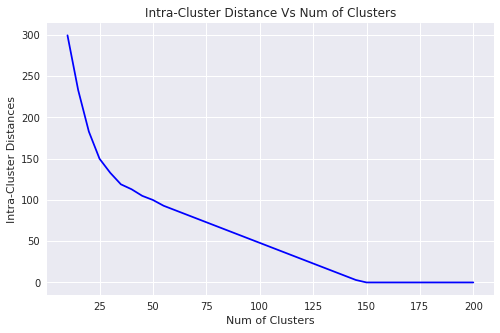

In [70]:
# find best k from the plot
find_best_k(word_clusters)

#### Observation:
* From this curve it seems after 50 clusters the slope of the curve decreases. So, I'm taking 50 as the best-fit K.

In [95]:
cluster25 = word_clusters[3]

In [98]:
np.array(topwords)[cluster25.labels_ == 22]

array(['phabul', 'phantast', 'phresh'], dtype='<U25')

#### Observation:
* I have stemmed the words so the words here are a little difficult to interpret but here these words are fabulous, fantastic and fresh. So, this cluster is about positive adjective with similar stem of word. 

In [126]:
np.array(topwords)[cluster25.labels_ == 4]

array(['essigbasierten', 'eignet', 'eher', 'einem', 'eintrocken'],
      dtype='<U25')

#### Observation:
*  This one is an interesting cluster here which has clustered the german words.

In [138]:
np.array(topwords)[cluster25.labels_ == 17]

array(['eulalia', 'piedad', 'epenisa', 'peligroso'], dtype='<U25')

#### Observation:
* Again this cluster is an amazing one, which contains spanish word along with spain's famous persons.

In [149]:
np.array(topwords)[cluster25.labels_ == 1]

array(['phagocytos', 'pharmacol', 'endogen', 'physiol'], dtype='<U25')

#### Observation:
* All these words in this cluster are related to medical science. 

## 8. Summary 

#### Approach:
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  The Amazon Fine Food dataset is used here to cluster them in some groups. I have taken only 2000 top words from TFIDF representation as calculating co-occurrence matrix takes much time. I used Truncated SVD to find word vector representation and applied K-Means clustering to it to cluster similar words together.
<br>
#### Conclusion:
* Both Truncated SVD and K-Means clustering performed impressively well as the final clusters are very much meaningful. 